In [12]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
  
plt.style.use('fivethirtyeight')

In [13]:
filename = './datas/apple.csv'
stock = pd.read_csv(filename)
stock.index = pd.to_datetime(stock.index)
stock = stock.asfreq(freq='D')
stock = stock.fillna(method='bfill')
stock.head()

,AAPL
2013-03-11,13.506429
2013-03-12,13.215249
2013-03-13,13.212777
2013-03-14,13.340788
2013-03-15,13.685024


Text(0.5, 0, 'Date')

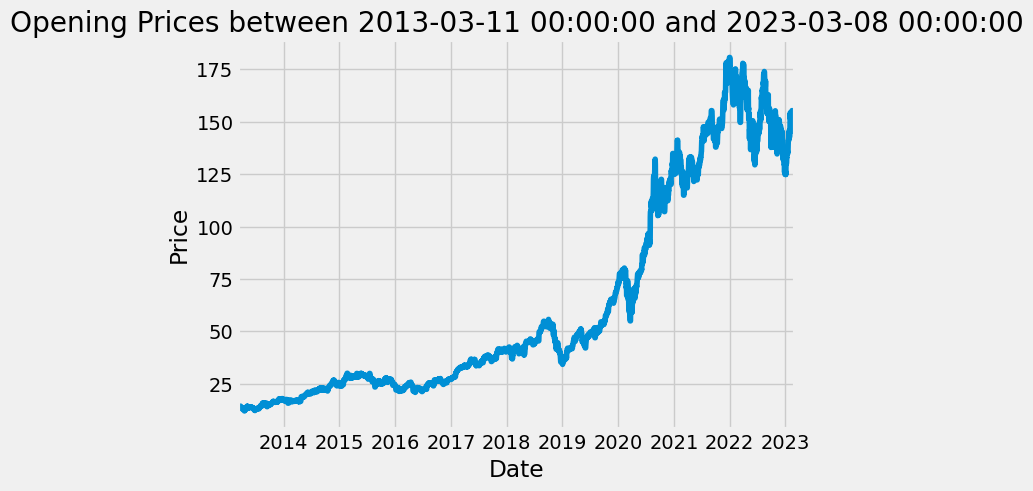

In [14]:
import matplotlib.pyplot as plt
start_date = stock.first_valid_index()
end_date = stock.last_valid_index()
plt.title(f'Opening Prices between {start_date} and {end_date}')
stock['AAPL'].plot()
plt.ylabel('Price')
plt.xlabel('Date')

## Train / Test split

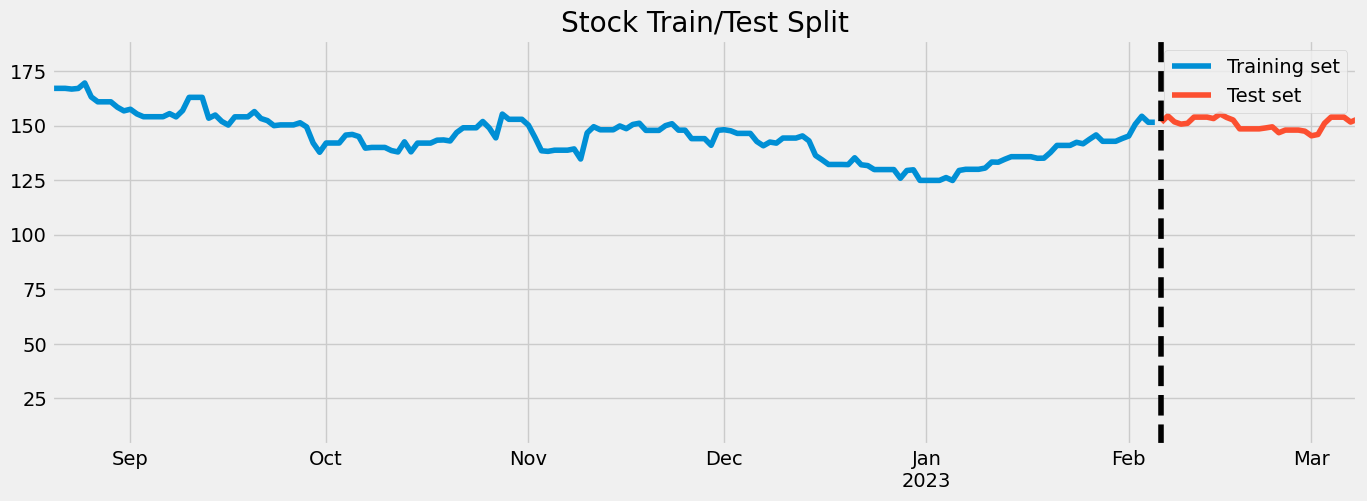

In [15]:
split_date = pd.to_datetime(stock.last_valid_index()) - timedelta(days=30)
train = stock.loc[stock.index < split_date]
test = stock.loc[stock.index >= split_date]
fig, ax = plt.subplots(figsize=(15,5))

train.plot(ax=ax, label='train', title='Stock Train/Test Split')
test.plot(ax=ax, label='test')
plt.xlim([end_date - timedelta(days=200), end_date])
ax.axvline(split_date, color='black', linestyle='--')
ax.legend(['Training set', 'Test set'])

## Features Creation

In [16]:
def create_features(data: pd.DataFrame):

    data = data.copy()
    # from autocorrelation analysis, seasonal variation for 12 months
    data['year'] = data.index.year
    data['month'] = data.index.month
    # from partial autocorrelation analysis, lag 1, lag 2, lag 13
    data['lag_1'] = data[data.columns[0]].shift(1)
    data['lag_2'] = data[data.columns[0]].shift(2)
    # data['lag_13'] = data['Passengers'].shift(13)
    return(data)


In [17]:

train = create_features(train)
test = create_features(test)

FEATURES = ['year', 'month', 'lag_1', 'lag_2']
TARGET = stock.columns[0]


In [18]:
test.head()

,AAPL,year,month,lag_1,lag_2
2023-02-06,151.498688,2023,2,NaN,NaN
2023-02-07,154.414230,2023,2,151.498688,NaN
2023-02-08,151.688400,2023,2,154.414230,151.498688
2023-02-09,150.639999,2023,2,151.688400,154.414230
2023-02-10,151.009995,2023,2,150.639999,151.688400


In [19]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

## Create Model

In [20]:
model = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
model.fit(X_train,y_train, 
            eval_set=[(X_train, y_train),(X_test, y_test)],
            verbose=True
        )

[0]	validation_0-rmse:55.50950	validation_1-rmse:108.28700
[1]	validation_0-rmse:38.98230	validation_1-rmse:78.31269
[2]	validation_0-rmse:27.38229	validation_1-rmse:57.95479
[3]	validation_0-rmse:19.24830	validation_1-rmse:44.83886
[4]	validation_0-rmse:13.55021	validation_1-rmse:36.58548
[5]	validation_0-rmse:9.56034	validation_1-rmse:31.51522
[6]	validation_0-rmse:6.77773	validation_1-rmse:28.62735
[7]	validation_0-rmse:4.84961	validation_1-rmse:27.00956
[8]	validation_0-rmse:3.52984	validation_1-rmse:26.13527
[9]	validation_0-rmse:2.63611	validation_1-rmse:25.66066
[10]	validation_0-rmse:2.04504	validation_1-rmse:25.41424
[11]	validation_0-rmse:1.67056	validation_1-rmse:25.29904
[12]	validation_0-rmse:1.43613	validation_1-rmse:25.23586
[13]	validation_0-rmse:1.29704	validation_1-rmse:25.17696
[14]	validation_0-rmse:1.22064	validation_1-rmse:25.14313
[15]	validation_0-rmse:1.16818	validation_1-rmse:25.12474
[16]	validation_0-rmse:1.13282	validation_1-rmse:25.09236
[17]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<AxesSubplot: title={'center': 'FEATURES Importance'}>

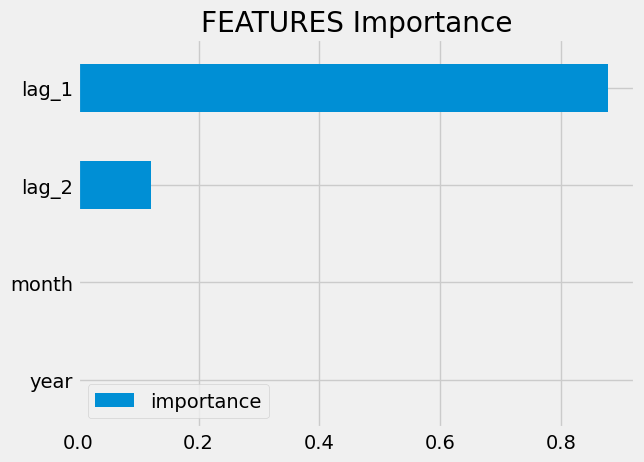

In [21]:
fi = pd.DataFrame(data=model.feature_importances_, index=model.feature_names_in_ , columns=['importance'])
fi.sort_values(by='importance', ascending=True).plot(kind='barh', title='FEATURES Importance')

In [22]:
test['prediction'] = model.predict(X_test)

data = stock.merge(test[['prediction']], how='left', left_index=True, right_index=True)
data.tail()

,AAPL,prediction
2023-03-04,153.830002,150.030365
2023-03-05,153.830002,151.362808
2023-03-06,153.830002,151.362808
2023-03-07,151.600006,151.362808
2023-03-08,152.869995,150.993774


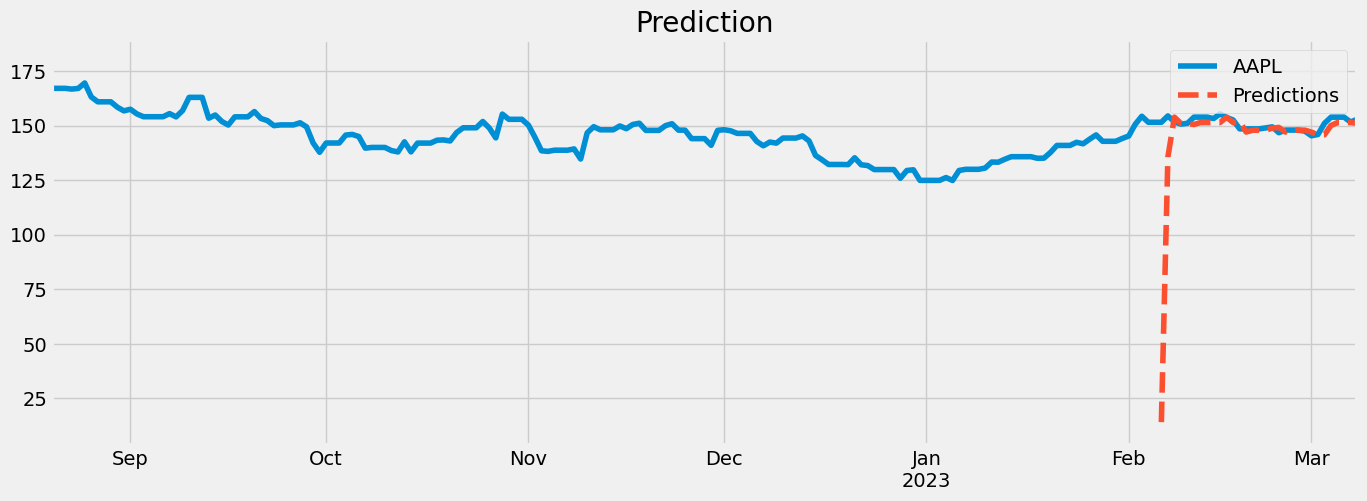

In [23]:
ax = stock[[stock.columns[0]]].plot(figsize =(15,5))
test['prediction'] .plot(ax=ax, style='--', label='2 lags Prediction')
plt.xlim([end_date - timedelta(days=200), end_date])
ax.set_title('Prediction')
ax.legend([stock.columns[0], 'Predictions'])

In [24]:
score = np.sqrt(mean_squared_error(y_test, test['prediction']))
print(f'RMSE Score on test set: {score:0.2f}')

RMSE Score on test set: 24.99


2. Stats models

2013-03-11     13.326284
2013-03-12     13.414799
2013-03-13     13.503314
2013-03-14     13.582047
2013-03-15     13.660704
                 ...    
2023-03-04    150.762859
2023-03-05    151.842858
2023-03-06    151.864951
2023-03-07    152.498472
2023-03-08    153.131992
Freq: D, Name: trend, Length: 3650, dtype: float64

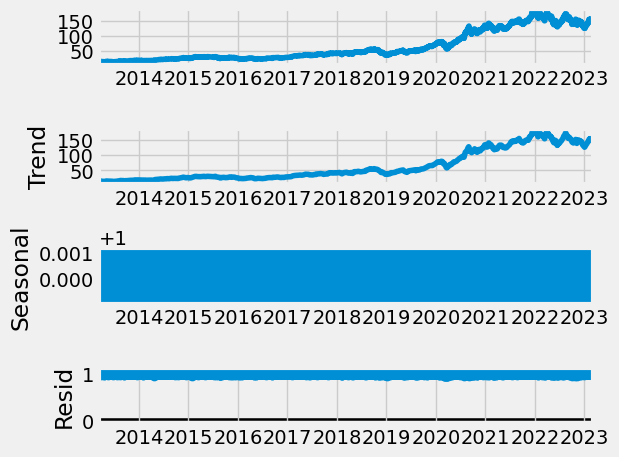

In [25]:
seasonal_decompose(stock, model="multiplicative").plot()
decompose_results = seasonal_decompose(stock, model="multiplicative", extrapolate_trend='freq')
decompose_results.trend

In [26]:
## 👉Step5: Train and Test split

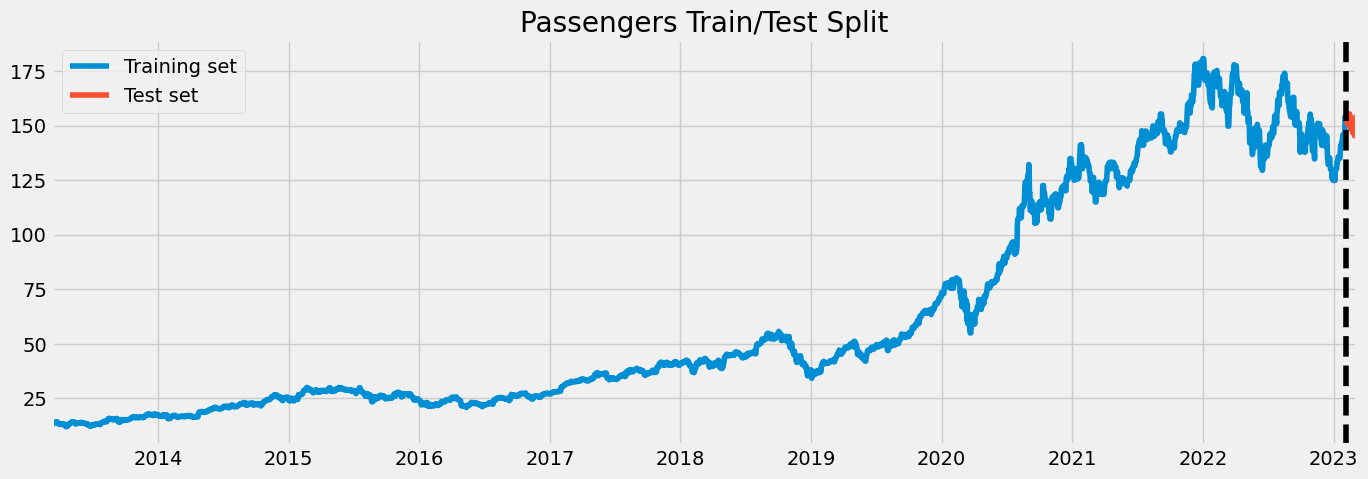

In [28]:
train = stock.loc[stock.index < split_date]
test = stock.loc[stock.index >= split_date]
fig, ax = plt.subplots(figsize=(15,5))

train.plot(ax=ax, label='train', title='Passengers Train/Test Split')
test.plot(ax=ax, label='test')
ax.axvline(split_date, color='black', linestyle='--')
ax.legend(['Training set', 'Test set'])

In [29]:
arima_model = auto_arima(train, start_p=0, d=1,
                         start_q=0,
                         max_p=5, max_d=5, max_q=5,
                        #  start_P=0, D=1,
                        #  start_Q=0, max_P=5, max_D=5, 
                        #  max_Q=5, 
                         m=12, seasonal=False, 
                         error_action='warn',trace=True, 
                         suppress_warnings=True, stepwise=True, 
                         random_state=20, n_fits=50)

c:\Python310\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12333.027, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12334.037, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12334.034, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12334.002, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12332.673, Time=0.60 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12338.029, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12334.389, Time=0.65 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=12336.018, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12336.031, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=12337.097, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 4.308 seconds


In [35]:
pred_horizon = test.shape[0]
y_prediction, conf_int  = arima_model.predict(pred_horizon,return_conf_int=True,alpha=0.05)
prediction = pd.DataFrame({'predicted_': y_prediction, 'low_int': conf_int[:,0], 'high_int': conf_int[:,1]}, index=test.index)
# prediction.columns = ['predicted_passenger']
prediction

,predicted_,low_int,high_int
2023-02-06,151.467201,148.862735,154.071668
2023-02-07,151.454334,147.814334,155.094335
2023-02-08,151.455101,147.040498,155.869705
2023-02-09,151.465852,146.409764,156.521941
2023-02-10,151.483914,145.869579,157.098249
2023-02-11,151.507329,145.392478,157.622180
2023-02-12,151.534664,144.962039,158.107289
2023-02-13,151.564870,144.567603,158.562137
2023-02-14,151.597178,144.201858,158.992498
2023-02-15,151.631025,143.859574,159.402476


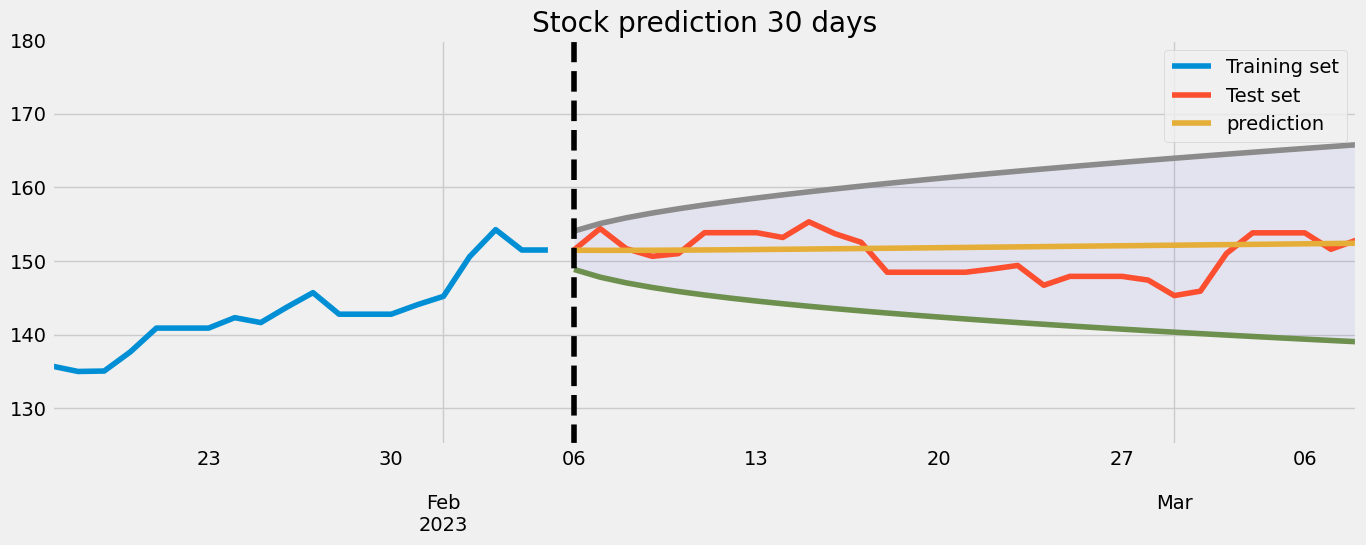

In [38]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='train', title='Stock prediction 30 days')
test.plot(ax=ax, label='test')
prediction.plot(ax=ax, label='predicted_')
ax.fill_between(prediction.index, (prediction['low_int']), (prediction['high_int']), color='b', alpha=.05, linewidth=0)
ax.axvline(split_date, color='black', linestyle='--')
plt.xlim([end_date - timedelta(days=50), end_date])
plt.ylim([125, 180])
ax.legend(['Training set', 'Test set', 'prediction'])